# Modeling the Perfectly Roasted Marshmallow

Leila Merzenich and Nathan Weil


What roasting tempurature and time will create the perfectly roasted marshmallow?

In [43]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

Here we are defining the values of our initial state

In [50]:
eTemp=360
#360*2.33*2.02
#oTemp=mTemp=iTemp=290
#outer=middle=inner=(2.33*2.02)*oTemp
290*(2.33*2.02)
1364.914/(2.33*2.02)

290.0

(Haven't yet figured out how to include this into the code,
we will eventually make it a sweep, 
I just hard-coded these values for now)

In order to understand the heat transfer proccess through the marshmallow from the outside air, we separated the marhsmallow into three concentric sections with the same masses and varying thicknesses.

The energy held each sub-section are each a stock, as well as the temperature that the amount of energy creates, 
   because the temperatures and energies all effect each other and need to be calculated over time.
   The mass of each ring in the marshmallow is the same, and the thickness and surface area are based on that.
   We used the conductivity of bread as a proxy for that of a marshmallow. 
   We were able to find data of the specific heat of a marshmallow.

In [51]:
def make_system(eTemp):
   
    init = State(outer=1364.914, middle=1364.914, inner=1364.914, 
                 oTemp=290, mTemp=290, iTemp=290)
    dt=0.1 #size of the time steps
    conductivity=0.1 #thermal conductivity
    areaOuter=0.004054 #surface are of a marshmallow
    areaMiddle=0.003091 #surface area of the middle section of the marshmallow
    areaInner=0.001946 #surface are of the inner section
    thicknessOuter=0.00161 #thickness of the outer layer
    thicknessMiddle=0.00229 #thickness of the middle layer
    thicknessInner=0.0088 #thickness of the inner core
    mass=2.33 #each layer has the same mass
    specificMarshmallow=2.02 #specific heat capacity of a marshmallow
    t0=0
    t_end=1000 #in seconds

    
    return System(init=init, dt=dt, conductivity=conductivity, 
                  areaOuter=areaOuter, areaMiddle=areaMiddle, 
                  areaInner=areaInner, thicknessOuter=thicknessOuter, 
                  thicknessMiddle=thicknessMiddle, 
                  thicknessInner=thicknessInner, mass=mass, 
                  specificMarshmallow=specificMarshmallow, t0=t0, t_end=t_end)

In order to calculate the heat transfered from the outside air to the marshmallow and from each section to the inner section, we used the following equations:

dQ/dt=(kA(T2-T1))/d

T=Q/mc

Q=heat transfered

k=thermal conductivity

A=surface area

T1=first temp

T2=second temp

d=thickness

m=mass

Cmarshmallow=specific heat

At each step, we will add the energy transfered from the next outer section and subtract the energy transfered to the next inner section using the temperature from the previous time step. The temperature is recalculated at each step using the total energy during that timestep.

In [52]:
def update_func(state, t, system):
    """Updates the energy in the sections, then based on this calculates and stores the temperature of each section
    """
    outer, middle, inner, oTemp, mTemp, iTemp = state
    unpack(system)
    dQdt1 = (conductivity*areaOuter*(eTemp-oTemp))/thicknessOuter #energy transfered from outside air to outer layer
    dQdt2 = (conductivity*areaMiddle*(oTemp-mTemp))/thicknessMiddle #from outer to midle layer
    dQdt3 = (conductivity*areaInner*(mTemp-iTemp))/thicknessInner #middle to inner layer
    #W/mK*m^2*K/m = W
    
    outer += (dQdt1 - dQdt2)*dt #add energy transfered from air and subtract energy lost to middle layer
    middle += (dQdt2 - dQdt3)*dt #add energy from outer and subtract energy to inner
    inner += (dQdt3)*dt #add energy from middle
    
   
    iTemp = inner/(mass*specificMarshmallow) #energy/(kg*energy/(kg*K)) = K
    mTemp = middle/(mass*specificMarshmallow)
    oTemp = outer/(mass*specificMarshmallow)
 
    return State(outer=outer, middle=middle, inner=inner, oTemp=oTemp, mTemp=mTemp, iTemp=iTemp)

In [53]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    for t in linrange(t0, t_end, dt):
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

In [54]:
def plot_results(oTemp, mTemp, iTemp):
    
    plot(oTemp, '--', label='Outer Temp')
    plot(mTemp, '-', label='Middle Temp')
    plot(iTemp, '-', label='Inner Temp')
    decorate(xlabel='Time (seconds)',
             ylabel='Tempurature(K)')

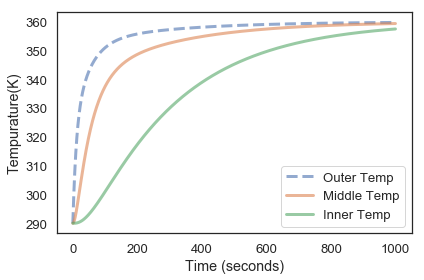

In [55]:
system = make_system(eTemp)
results = run_simulation(system, update_func)

plot_results(results.oTemp, results.mTemp, results.iTemp)